In [1]:
# @title If running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/neurovium/Neuromatch-AJILE12
    %cd Neuromatch-AJILE12
    %pip install -e . --quiet

Cloning into 'Neuromatch-AJILE12'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (292/292), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 292 (delta 130), reused 225 (delta 71), pack-reused 0
Receiving objects: 100% (292/292), 9.15 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/Neuromatch-AJILE12
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.1/197.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
# Numerical and plotting packages
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import natsort
import scipy.signal
from scipy.signal import sosfiltfilt, butter, hilbert, chirp
# Libraries needed for this notebook to interact with the DANDI API
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient

# Libraries needed for this notebook to interact with NWB events
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events

# FSSpec is a library that allows us to read files from the cloud
import fsspec

# NWB is based on HF5, so we need this library to read NWB files
import h5py
from fsspec.implementations.cached import CachingFileSystem

import matplotlib.pyplot as plt
from scipy.integrate import simps

/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Getting a list of Path Locations

In [3]:
with DandiAPIClient() as client:
    paths = []
    for file in client.get_dandiset("000055", "draft").get_assets_with_path_prefix(""):
        paths.append(file.path)
paths = natsort.natsorted(paths)
# print(paths)

#Functions

## Access to data on cloud

In [4]:
def get_nwb(sbj, session):
    """ return nwbfile

    Parameters
    ----------
    sbj : _type_
        _description_
    session : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    path = f'sub-0{sbj}/sub-0{sbj}_ses-{session}_behavior+ecephys.nwb'
    with DandiAPIClient() as client:
        asset = client.get_dandiset("000055").get_asset_by_path(
            path=path)
        s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)


    # Note, caching is set once per access. If you want to change the cache location, you will need to restart the kernel.
    fs = CachingFileSystem(
        fs=fsspec.filesystem("http"),
        # cache_storage="nwb-cache",  # Local folder for the cache
    )

    f = fs.open(s3_path, "rb")
    file = h5py.File(f)
    io = NWBHDF5IO(file=file, mode='r', load_namespaces=True)
    nwbfile = io.read()

    return nwbfile, fs

In [5]:
# @title enter participant and session here
sbj_session, fs = get_nwb(1,3)

/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [6]:
# @title file overview
sbj_session.electrodes[:]

,x,y,z,imp,location,filtering,group,group_name,standard_deviation,kurtosis,median_deviation,good,low_freq_R2,high_freq_R2
id,,,,,,,,,,,,,,
0,-45.648495,38.560372,36.187962,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x1331958...,GRID,35.398535,6.154781,28.978650,False,0.013106,-0.001107
1,-47.347152,31.182861,41.176799,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x1331958...,GRID,55.518727,1.309332,48.247142,True,-0.004729,-0.019041
2,-50.291409,22.157208,45.191885,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x1331958...,GRID,33.992008,1.585154,31.077800,True,-0.003226,-0.003235
3,-51.358961,11.787268,48.726509,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x1331958...,GRID,33.701261,2.652564,28.651509,True,0.036002,-0.013343
4,-51.219818,1.713889,53.000981,NaN,unknown,250 Hz lowpass,GRID pynwb.ecephys.ElectrodeGroup at 0x1331958...,GRID,59.648470,2.626867,51.301159,True,0.096380,-0.014212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,-34.106273,-88.149114,-19.819989,NaN,unknown,250 Hz lowpass,LTO pynwb.ecephys.ElectrodeGroup at 0x13319588...,LTO,58.315750,2.708134,42.559665,True,-0.009470,-0.007675
90,-44.753871,-80.476379,-19.968393,NaN,unknown,250 Hz lowpass,LTO pynwb.ecephys.ElectrodeGroup at 0x13319588...,LTO,55.756859,3.443116,40.267286,True,-0.008794,-0.011022
91,-51.026277,-73.221686,-18.328451,NaN,unknown,250 Hz lowpass,LTO pynwb.ecephys.ElectrodeGroup at 0x13319588...,LTO,48.797883,2.870422,35.445855,True,-0.002914,-0.013156


In [7]:
# @title tasks that happen during the session
def tasks_per_sess(sbj_session):
  clabels_orig = sbj_session.intervals['epochs'].to_dataframe()
  labels = clabels_orig['labels'].to_list()
  labels = list(set(labels))
  return labels

labels = tasks_per_sess(sbj_session)

In [8]:
# @title number of ECoG channels
def n_channels(sbj_session):
  ch = sbj_session.electrodes[:]
  ch = pd.DataFrame(ch)
  idx_false = np.where(ch['good'] == False)[0] #idx of bad channels
  #ch = ch[ch['good'] != False] # remove bad channel
  ch = ch['group_name']
  return ch, idx_false

ch, idx_false = n_channels(sbj_session)
#ch = ch[ch[0] == 'GRID']  # raw data for electrodes?

In [9]:
# @title Function to extract the data according to the task

def extract_raw_data_task(behavior_type):

    """
        Function to extract the data according to the task.

        Args:
          behavior_timestaps: str of task

        Return:
          neur_data_df: a DataFrame that contains EOG/ECG recordings according timestamps
          neur_data_task: a List with signals per electros

          Each column represents an electrode. The lines are the raw ECoG signals.
          The sampling frequency is 500 Hz.
          I took the time span of each task and took the raw ECoG data that corresponded
          to that time. I put all the pieces together in a DataFrame according to the task
    """

    ecog_ch_num = [i for i in range(len(ch))] # electrode number over motor cortex
    behavior_type = behavior_type # select the task


    # get coarse labels from NWB file
    min_len = 100  # (sec) only keep times when the given label appears for longer than this amount of time at once

    coarse_labels = sbj_session.intervals['epochs'].to_dataframe() #timestaps
    coarse_labels = coarse_labels[coarse_labels['labels'] == behavior_type] # select column timestaps of behavior
    coarse_labels['diff'] = coarse_labels['stop_time'] - coarse_labels['start_time'] # timestaps of behavior
    coarse_labels = coarse_labels[coarse_labels['diff'] > min_len] # conditions
    coarse_labels.reset_index(inplace=True, drop=True)

    # Print the coarse labels as a table
    #print(coarse_labels)

    neural_data = sbj_session.acquisition['ElectricalSeries'].data # raw data
    sampling_rate = sbj_session.acquisition['ElectricalSeries'].rate  # (Hz) ECoG sampling rate
    neur_data_task = []

    for i in range(coarse_labels.shape[0]):
        # Identify the start/end indices for each continuous chunk of the given behavioral label
        start_t = int(coarse_labels.loc[i, 'start_time']*sampling_rate)
        end_t = int(coarse_labels.loc[i, 'stop_time']*sampling_rate)

        # Load data snippet
        neur_data_curr = neural_data[start_t:end_t, ecog_ch_num]


        #add for list neur_data_task
        neur_data_task.extend(neur_data_curr)

        # creating DataFrame of data task
        neur_data_df = pd.DataFrame(neur_data_task)

        return neur_data_df, neur_data_task


In [10]:
# @title
tasks = [ 'Sleep/rest', 'Inactive', 'Talk','TV','Computer/phone'] #task focuos  # 'Eat'

# REMEMBER TO CHECK WHAT TASKS THIS PARTICIPANT HAS IN THIS SESSION.

List_DFs = [] # list of DataFrames
#List_np = [] # Numpy List
for i in tasks :
  print(i)
  neur_data_df, neur_data_task = extract_raw_data_task(i) #enter the task
  #print(neur_data_df )
  List_DFs.append(neur_data_df) # storing the list List_DFs
  #neur_data_np = neur_data_df.values # transforming to Numpy
  #List_np.append(neur_data_np) # storing the list List_np

# neur_data_df

# P.S. THE INDEX ORDER FOLLOWS THE ORDER OF THE TASKS IN THE TASKS LIST

Sleep/rest
Inactive
Talk
TV
Computer/phone


In [11]:
List_DFs[1]

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,-16.313848,153.223083,-15.768907,-30.484852,-74.689224,-79.103943,31.765465,-8.646074,-47.367741,-41.518959,...,51.077579,-14.348599,5.177324,1.988968,-55.827423,3.679482,23.947128,13.302048,-3.679485,-32.006561
1,-21.641903,138.124466,-22.320488,-38.911148,-84.663925,-82.917694,38.026989,5.663452,-49.606209,-64.901413,...,38.460358,-23.934893,4.981686,5.596058,-75.417145,28.817177,14.433105,11.401329,-11.401325,-36.572872
2,-15.456358,127.924637,-16.877768,-39.320885,-84.905602,-86.075882,47.701641,33.893173,-40.643604,-72.259911,...,25.306894,-30.444471,10.685186,8.548214,-68.472488,29.000458,11.446037,33.962128,-15.104141,-11.446045
3,-14.122623,125.078224,-14.158159,-38.370968,-86.690773,-81.759888,54.741287,55.012749,-35.190094,-73.984070,...,4.967678,-46.927696,2.285816,4.943848,-67.472687,35.982689,-0.457428,44.050644,-18.003876,0.457420
4,-13.994930,123.676003,-13.453228,-39.059711,-88.471100,-68.994682,55.095406,67.703728,-30.684216,-70.969269,...,6.221643,-51.389103,7.313507,12.045467,-65.857849,16.937805,5.517548,41.309677,-6.397030,-5.517548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58679,17.594067,-99.711555,-32.954849,-12.038426,-23.418602,-15.639499,42.859055,-57.514469,17.827282,-16.027367,...,-63.836838,-18.174917,47.663033,18.174917,-111.979408,-105.977554,26.856873,67.544365,11.966610,-11.966614
58680,12.961334,-95.442093,-17.556337,-7.729326,-20.618763,-11.609959,50.944355,-58.676460,13.272076,-22.115505,...,-59.016819,-16.153015,43.875698,16.153015,-127.122337,-118.415665,25.879204,39.490265,15.303299,-15.303303
58681,13.950663,-86.201614,1.011692,-5.298431,-14.108267,-8.850704,57.677574,-57.262787,15.625948,-25.716839,...,-49.751312,-14.805653,37.983292,14.805653,-132.936890,-118.854790,35.337852,25.595490,9.440235,-9.440235
58682,8.845703,-81.421303,13.041840,-7.372248,-18.226479,-9.172130,61.715176,-54.222107,12.696980,-36.447971,...,-46.132759,-15.046610,32.871017,15.046610,-138.233231,-113.120773,46.057217,14.869373,12.894463,-12.894463


In [12]:
# @title Remove bad channels
for df in List_DFs:
    # Use the drop() function to remove the unwanted columns
    df.drop(df.columns[idx_false], axis=1, inplace=True)

In [13]:
# @title Signal-to-Noise Ratio (SNR)

def calculate_snr(signal, noise):
    """
    Calculate the Signal-to-Noise Ratio (SNR) of a signal in dB.

    Parameters:
        signal (array-like): The signal of interest.
        noise (array-like): The noise signal (baseline or background noise).

    Returns:
        float: The SNR value in dB.
    """

    # Calculate the Root Mean Square (RMS) of the signal and noise over a specified window (first 50000 samples).
    rms_signal = np.sqrt(np.mean(np.square(signal[:50000] - noise[:50000])))
    rms_noise = np.sqrt(np.mean(np.square(noise[:50000])))

    # Calculate the Signal-to-Noise Ratio (SNR) in dB.
    snr = 20 * np.log10(rms_signal / rms_noise)

    return np.array(snr)

snr = calculate_snr(List_DFs[2], List_DFs[1])
Z_scores = (snr - snr.mean()) / snr.std()
print(Z_scores)

[-3.5792953e-01 -2.9168037e-01 -7.0952570e-01 -1.0349586e+00
 -6.4429963e-01 -4.3409091e-01 -4.6866658e-01 -1.0372104e-01
 -2.4897212e-01 -3.7243941e-01 -1.6877805e+00 -1.3767539e+00
 -1.5956453e+00 -1.3453419e+00 -7.6933008e-01  5.8946740e-03
 -5.0963098e-01 -4.4633654e-01 -1.2461873e+00 -1.2282205e+00
 -1.8812525e+00 -1.5571151e+00  7.1960169e-01 -9.2501158e-01
 -4.5331129e-01 -1.4723734e+00 -9.2900336e-01 -1.8962823e+00
 -1.6071725e+00  8.3224815e-01  3.3135188e-01  9.4459283e-01
  1.0388942e-01 -1.5420960e+00 -1.4564193e+00 -6.7617995e-01
  1.5958623e+00  1.4790447e+00  5.8170986e-01  8.6193848e-01
  4.0658448e-02 -7.3640645e-01 -2.0648844e-03 -1.5076423e-01
  2.1123645e+00  1.7240409e+00  1.4758198e+00  8.8538092e-01
  3.4562922e-01  8.3923817e-01  3.2865885e-01  5.5883771e-01
  2.0907416e+00  1.5731947e+00  9.8642886e-01  7.5539762e-01
  6.3684918e-02  3.2934415e-01  2.9962882e-01  5.4292881e-01
  3.3823365e-01  8.1290233e-01  3.5209301e-01 -6.6679305e-01
 -1.1795127e+00 -1.17946

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  Examples
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  Examples


In [14]:
# @title Z scores
def Z_scores(signals):
    """
    Calculate the Z-scores for a specific DataFrame in the List_DFs.

    Parameters:
        siganl: a array 1D with signal per electrode

    Returns:
        DataFrame: a new DataFrame containing the standardized Z-scores for each column of the selected DataFrame.
    """

    # Assuming 'List_DFs' is the list of DataFrames, and 'n_task' is the index of the DataFrame we want to process.

    # Calculate the mean and standard deviation of each column in DataFrame n_task.
    mean_values = signals.mean()
    std_values = signals.std()

    # Calculate the Z-scores for each value in each column of DataFrame n_task.
    Z_scores = (signals - mean_values) / std_values

    # Return the new DataFrame with standardized Z-scores.
    return Z_scores

In [15]:
# @title Time
def time(idx_DF, fs):

  """
      Calculate the time array for a specific data frame.

      Args:
          idx_DFs: an int referring to the index of the DF corresponding to the task
          fs: sampling frequency (Hz)

      Returns:
          t: an np.Array with time (sec)
  """

  np_time = List_DFs[idx_DF][1]
  N = len(np_time)
  fs = fs
  T = 1/fs
  t = np.arange(0, N/fs, T)
  return t


In [16]:
# @title Fast Fourier Transform  (FFT)

def FFT(siganls, fs):

  """
      Calculate Fast Fourier Transform.

      Args:
          siganls: a array 1D with signal per electrode
          fs: an int sampling frequency (Hz)

      Return:
          f: A numpy array containing the different frequencies present in a signal after applying the Fourier Transform.
          transf: A numpy array containing the Fourier Transform of the signal. The Fourier Transform values represent the amplitudes of the frequency components present in the original signal.

  """

  N = len(siganls) # size of the Fourier transform (number of points in the signal in the time domain).
  fs = fs # sampling frequency (Hz)
  T = 1/fs # time interval between signal points

  f = np.fft.fftfreq(N, T) # is used to discover the different frequencies present in a signal after applying the Fourier Transform.
  transf = np.fft.fft(siganls) # FFT
  transf = np.abs(transf)

  transf = transf[f>0] # positive range
  f = f[f>0] # positive range

  return f, transf

In [17]:
# @title FFT Plot
def plot_FFT(f, transf):

  plt.figure(figsize=(20, 5))
  plt.plot(f, transf, label="FFT Amplitude")  # Add label to the curve
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Amplitude')
  plt.title('Fast Fourier Transform')
  plt.legend()  # Show the legend
  plt.grid(True)
  plt.show()

In [18]:
# @title Bandpass Filter
def BandPass_Filter(signal, fs, lowcut, highcut):
    """
    Apply a bandpass filter to a signal.

    Args:
        signal: a array 1D with signal per electrode
        fs: A sampling rate (sampling frequency) of the signal in Hz.
        lowcut: Lower cutoff frequency of the bandpass filter in Hz.
        highcut: Upper cutoff frequency of the bandpass filter in Hz.

    Returns:
        y: A bandpass filtered signal a 1D numpy array.
    """

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 4  # Order of the Butterworth filter

    # Retrieve the electrode signal from the DataFrame (DF) and electrode index.

    # Design the bandpass filter using the scipy.signal.butter function.
    # The function returns the filter coefficients in polynomials b (numerator) and a (denominator).
    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)

    # Apply the bandpass filter to the signal using the scipy.signal.filtfilt function.
    # This function filters the signal in both forward and reverse directions to avoid phase delays.
    y = scipy.signal.filtfilt(b, a, signal, axis=0)

    return y

In [19]:
# @title Bandpass Filter Plot
def plot_bandpass(signal_orig, filtered_signal,  fs):
    """
    Plots the original and filtered signals.

    Args:
        filtered_signal: A 1D numpy array containing the filtered signal.
        signal_orig:  A 1D numpy array containing the raw signal.
        fs: The sampling rate (sampling frequency) of the signal in Hz.

    Returns:
        None
    """

    # Calculate the time axis based on the sampling rate and signal length
    t = np.arange(len(filtered_signal)) / fs

    # Plot the original signal
    plt.figure(figsize=(12, 6))
    plt.plot(t, signal_orig, label="Original Signal", color="red")

    plt.plot(t, filtered_signal, label="Filtered Signal", color="blue")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Show both plots
    plt.legend()
    plt.show()

In [20]:
# @title Spectogram
def spectrogram(signal, fs, win):
    """
    Calculate the spectrogram of a signal.

    Args:
        signal: filtered signal
        fs: an integer representing the sampling frequency (Hz)

    Returns:
        f: a numpy array containing the frequencies present in the spectrogram.
        t: a numpy array containing the times associated with each time window of the spectrogram.
        Sxx: a 2D numpy array containing the spectrogram in a matrix format. Each element represents the spectral power density.
    """

    # Define the window function for the spectrogram. Here, we use the Hann window of length 1024.
    win = scipy.signal.windows.hann(win)

    # Calculate the spectrogram using the scipy.signal.spectrogram function.
    # The function takes the electrode data, sampling frequency (fs), window function (win),
    # and the amount of overlap between adjacent windows (noverlap).
    f, t, Sxx = scipy.signal.spectrogram(signal, fs, window=win, noverlap=len(win) // 2, scaling='spectrum')

    # Create a new figure with a size of 15x6 inches and a dpi (dots per inch) of 80.
    plt.figure(figsize=(15, 6), dpi=80)

    return f, t, Sxx

In [21]:
# @title Spectogram plot
def plot_spectogram(f, t, Sxx, channel):
    """
    Plot the spectrogram.

    Args:
        f: a numpy array containing the frequencies present in the spectrogram.
        t: a numpy array containing the times associated with each time window of the spectrogram.
        Sxx: a 2D numpy array containing the spectrogram in a matrix format. Each element represents the spectral power density.
        channel: a name of channel

    Returns:
        None (plots the spectrogram)
    """

    plt.figure(figsize=(15, 6), dpi=80)  # Set the size of the plot

    # Calculate the logarithm of the normalized spectrogram, normalized to the maximum value.
    # This is done to make the plot visually appealing and to enhance small differences in power.
    # The resulting values are in dB (decibels).
    log_Sxx = 10 * np.log10(Sxx / np.amax(Sxx))

    # Create a pseudocolor mesh plot of the spectrogram.
    # The x-axis represents time, the y-axis represents frequency, and the color represents the power in dB.
    # The 'shading' argument set to 'gouraud' ensures a smoother color transition between data points.
    # The 'vmin' argument sets the minimum value of the color scale (cmap), here set to -210 dB.
    # The 'cmap' argument specifies the color map to be used, in this case, the 'rainbow' colormap is used.
    p = plt.pcolormesh(t, f, log_Sxx, shading='gouraud', vmin=-50, cmap='rainbow')

    # Add a color bar to the plot to indicate the corresponding power values in dB.
    plt.colorbar(p, label='Power [dB]')

    plt.ylim([1, 100.0])  # Limit the y-axis to the frequency range of interest (1 Hz to 100 Hz).
    plt.xlabel("Time [s]")  # Label the x-axis as 'Time [s]'
    plt.ylabel("Frequency [Hz]")  # Label the y-axis as 'Frequency [Hz]'
    plt.title(f'Spectrogram - Channel {channel}')  # Set the plot title as 'Spectrogram'

    plt.show()  # Display the spectrogram plot

In [22]:
# @title Averange Band Power
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [23]:
# @title band power for filtered signal
def bandpower_task(filtered_dict, win, fs, lowcut, highcut):
    """
    Calculate the band power for each epoch of filtered data.

    Args:
        filtered_dict: a dictionary containing filtered data for different channels.
        win: an integer representing the length of the window used to divide the data into epochs.
        fs: an integer representing the sampling frequency (Hz) of the filtered data.
        lowcut: a float representing the lower frequency limit of the band of interest.
        highcut: a float representing the upper frequency limit of the band of interest.

    Returns:
        bandpower_dic: a dictionary containing the band power values for each epoch of each channel.
    """

    # Initialize an empty dictionary to store the band power values for each channel.
    bandpower_dic = {}

    # Iterate over each channel in the filtered_dict.
    for channel in filtered_dict:
        # Initialize an empty list to store the band power values for each epoch of the current channel.
        bandpower_list = []

        # Add the list to the bandpower_dic with the channel name as the key.
        bandpower_dic[channel] = bandpower_list

        # Calculate the number of epochs for the current channel based on the specified window length.
        bins = win * fs
        n_epoch = int(len(filtered_dict[channel]) / bins)

        # Iterate over each epoch of the current channel.
        for n in range(n_epoch):
            # Calculate the start and end indices of the current epoch.
            idx_f = n * bins
            idx_l = idx_f + bins

            # Extract the epoch data from the filtered_dict.
            epoch = filtered_dict[channel][idx_f:idx_l]

            # Calculate the band power for the current epoch using the bandpower() function.
            bandpower_epoch = bandpower(epoch, fs, [lowcut, highcut], window_sec=None, relative=False)

            # Append the band power value to the bandpower_list for the current channel.
            bandpower_list.append(bandpower_epoch)

    return bandpower_dic

# Extracting data from the dataset

In [24]:
# @title Selecting the tasks and sessions the attendee has
tasks = [ 'Sleep/rest', 'Inactive', 'Talk','TV', 'Computer/phone','Eat'] #task focuos
sesions = [3,4,5,7]
bad_channels = []

In [25]:
# @title Initializing the dictionary
sleep_rest = []
inactive = []
talk = []
tv = []
computer_phone = []
eat = []

task_dictionary = {
    'Sleep/rest': sleep_rest,
    'Inactive': inactive,
    'Talk': talk,
    'TV': tv,
    'Computer/phone': computer_phone,
    'Eat': eat
    }

In [26]:
# @title Loop to extract the data
for n_sess in sesions:
  #extrair dado por sessão
  sbj_session, fs = get_nwb(1,n_sess)

  #tarefas em uma sessão
  labels = tasks_per_sess(sbj_session)

  #armazenando n de canais e canais ruins
  ch, idx_false = n_channels(sbj_session)
  bad_channels.extend(idx_false)

  #separando as tarefas que tem nessa sessão e são do nosso interesse
  tasks_focus = []
  for i in labels:
    if i in tasks:
      tasks_focus.append(i)
  #print(tasks_focus)

  #extrair dado de acordo com a tarefa e armazenar no dicionário
  for i in tasks_focus:
    #print(i)
    neur_data_df, neur_data_task = extract_raw_data_task(i) #enter the task
    #print(neur_data_df )
    task_dictionary[i].extend(neur_data_task)


/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.6.0 is already loaded.
  warn("Igno

In [27]:
# @title Convert each item in the dictionary to a DataFrame
for key in task_dictionary:
    task_dictionary[key] = pd.DataFrame(task_dictionary[key])
bad_channels = list(set(bad_channels))
# Remove specified columns from each DataFrame
for key in task_dictionary:
    task_dictionary[key] = task_dictionary[key].drop(columns=bad_channels)

In [28]:
#concat_df_SB = pd.DataFrame()
#for i in range(2):
#  n=len(task_dictionary[tasks[i]])
#  activity=[tasks[i]]*n
#  trial=task_dictionary[tasks[i]]
#  trial['activity'] = activity
# concat_df_SB=pd.concat([concat_df_SB, trial])
#  del trial, n, activity

In [29]:
#concat_df_SB.to_csv('concat_df.csv')

In [30]:
#concat_df_SB

# Average the spectral power of each activity

## Eat

In [31]:
# @title Dataset of Eat task
task_dictionary['Eat']

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,89,90,91,92,93
0,1.764892,-2.155718,52.903107,74.900223,5.993865,-36.096573,14.244959,26.719753,-29.573717,-13.637409,...,2.042759,-0.469707,-8.967988,0.469709,-28.015781,-49.431641,-14.000698,-21.587540,77.410934,33.000462
1,-3.572994,0.049763,50.591354,82.706284,7.317768,-46.297707,2.713255,15.992722,-10.859755,-15.257341,...,-0.019205,-2.268337,0.019205,22.557459,-7.644900,-55.002838,16.419907,-16.419907,92.694778,53.275394
2,-2.480824,7.455567,45.463387,82.134888,2.847798,-53.126900,-2.906131,3.590656,3.192756,-10.973528,...,-1.390476,-14.652356,1.390476,27.467663,-5.079542,-76.982559,22.223839,-22.223837,75.511269,54.006218
3,1.088211,11.056578,37.686893,73.172302,-4.531663,-58.744728,2.933165,-8.345037,12.489082,-9.922275,...,5.242029,-21.025869,-9.325383,26.543819,-5.242030,-76.565277,11.781299,-11.781300,83.070908,58.285980
4,4.266087,12.528521,31.645874,65.606766,-11.051789,-50.837498,9.352895,-13.421105,32.060177,-6.197234,...,3.963078,-21.061924,-19.160139,24.166786,-3.963079,-62.650764,-12.861835,12.861832,97.117020,70.402069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120578,-2.160091,21.878361,29.020264,31.967518,33.850883,72.108398,53.715527,22.069113,31.896755,11.689934,...,-55.856968,-22.819767,148.368378,227.673187,22.819767,20.184605,83.910782,-20.184608,-70.650497,115.950066
120579,4.438400,28.871105,23.608103,24.111732,28.100248,86.559959,56.507835,29.621731,32.575630,9.992794,...,-57.007217,-15.754888,127.285843,238.281189,15.754887,5.351196,78.516129,-12.617752,-53.236710,122.145859
120580,8.407337,36.484779,19.677225,14.531021,26.430492,100.815353,56.137695,32.676155,29.804600,8.940311,...,-54.869827,-12.676558,103.372131,239.912827,12.676556,-9.466278,71.508064,-16.886353,-34.885132,121.354431
120581,13.778860,43.535835,16.900425,9.440184,26.041485,109.432953,47.252201,33.524895,29.176178,5.215622,...,-48.909111,-12.214985,96.152771,237.433731,12.214987,-35.974518,47.441536,-36.917999,-21.840973,105.025200


In [32]:
# @title separate 90% for training and 10% for test _Eat
#en(task_dictionary['Eat'])
training_perc_Eat = int(len(task_dictionary['Eat'])*0.9)
training_Eat = task_dictionary['Eat'][:training_perc_Eat]
test_Eat = task_dictionary['Eat'][training_perc_Eat:]
print(training_Eat)

               1          2          3          4          5          6   \
0        1.764892  -2.155718  52.903107  74.900223   5.993865 -36.096573   
1       -3.572994   0.049763  50.591354  82.706284   7.317768 -46.297707   
2       -2.480824   7.455567  45.463387  82.134888   2.847798 -53.126900   
3        1.088211  11.056578  37.686893  73.172302  -4.531663 -58.744728   
4        4.266087  12.528521  31.645874  65.606766 -11.051789 -50.837498   
...           ...        ...        ...        ...        ...        ...   
108519  22.303072   5.379103   0.234642  32.668564 -10.802355  12.022650   
108520  20.869028  12.037480   0.964993  33.088730 -10.223791  19.208258   
108521  11.267911   3.617300   0.521475  32.873772  -4.685768   8.978575   
108522   3.369499   1.737600   1.718613  32.896622  -3.595181  -1.848642   
108523   7.559994  11.562818  12.019864  34.598457   0.333225  -5.078833   

               7          8          9          10  ...         83         84  \
0     

In [33]:
# @title filter each channel and plot spectogram
filtered_dict_Eat = {}
for channel in task_dictionary['Eat']:
  filter_signal_Eat = BandPass_Filter(task_dictionary['Eat'][channel], 500, 1, 100)
  filtered_dict_Eat[channel] = filter_signal_Eat
  #f, t, Sxx = spectrogram(filter_signal_Eat, 500, 100)
  #plot_spectogram(f, t, Sxx, channel)

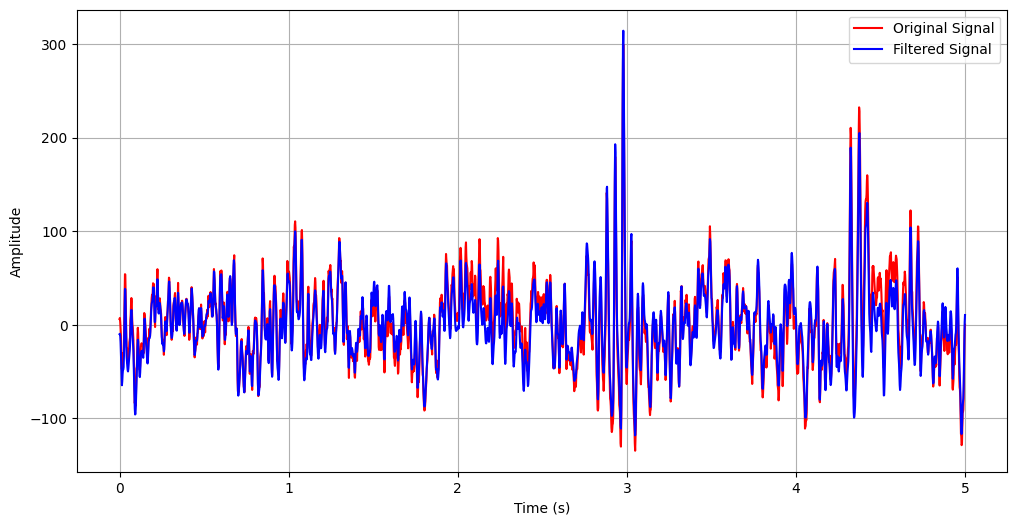

In [34]:
filter_signal_Eat = BandPass_Filter(task_dictionary['Eat'][5][:2500], 500, 1, 100)
plot_bandpass(task_dictionary['Eat'][5][:2500], filter_signal_Eat,  500)

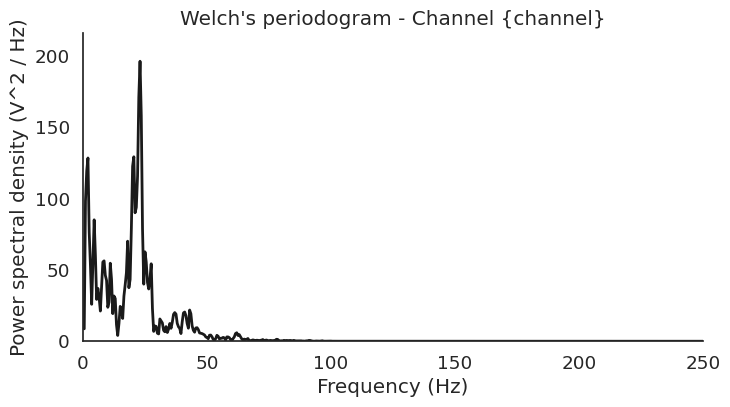

In [35]:
fs = 500.
win = 2 * fs
freqs, psd = scipy.signal.welch(filter_signal_Eat, fs, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram - Channel {channel}")
plt.xlim([0, freqs.max()])
sns.despine()

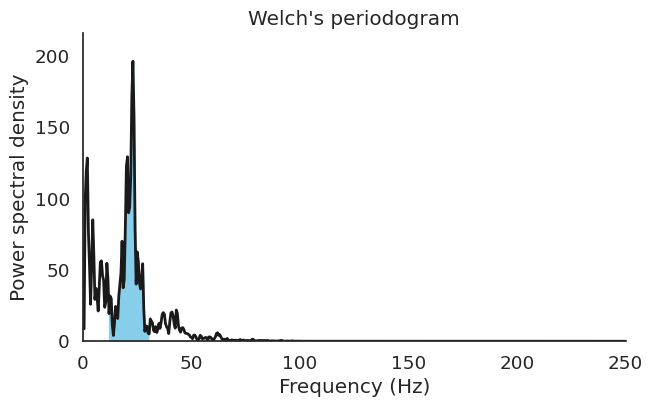

In [36]:
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.xlim([0, 250])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [37]:
# @title mean of band power
delta_Eat = bandpower_task(filtered_dict_Eat, 5, 500, 0.5, 4)
theta_Eat = bandpower_task(filtered_dict_Eat, 5, 500, 4, 8)
alpha_Eat = bandpower_task(filtered_dict_Eat, 5, 500, 8, 12)
beta_Eat = bandpower_task(filtered_dict_Eat, 5, 500, 12, 30)
gamma_Eat = bandpower_task(filtered_dict_Eat, 5, 500, 30, 100)

## Talk

In [38]:
# @title Dataset of Talk task
task_dictionary['Talk']

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,89,90,91,92,93
0,-20.129574,-27.018433,-3.704035,-124.821129,-21.621639,-77.117012,86.510292,8.111038,16.365557,17.197639,...,-6.280586,38.444992,101.901138,6.280582,-34.470844,-22.981846,57.598953,-39.262344,48.416870,22.981846
1,-22.061852,-28.810339,-4.372995,-119.589043,-12.845951,-81.950226,81.426613,8.870182,14.724457,18.744930,...,-14.017448,19.294579,98.260078,14.017452,-35.806412,-23.923153,35.347488,-34.613461,39.767586,23.923153
2,-19.095846,-26.999903,-2.556494,-113.926155,-5.566000,-78.636642,79.792183,11.998454,14.184347,20.599934,...,-5.097137,5.097134,99.435005,22.403095,-31.486992,-33.634609,13.509844,-42.606575,18.967337,14.867186
3,-18.588923,-26.039003,-1.948619,-104.947876,-11.273842,-74.765762,74.447746,17.042871,8.128873,19.052950,...,3.223820,-3.223816,94.415154,17.354206,-28.212597,-29.581158,1.371960,-45.502480,15.038280,4.228659
4,-20.418833,-23.975107,-0.125796,-90.533875,-17.956762,-75.469337,69.349907,26.684660,5.423850,11.361399,...,7.201572,-7.201569,98.862946,18.591930,-25.251749,-16.671412,6.370928,-33.850101,29.656807,7.244774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239327,46.898254,6.359259,-15.165044,7.250649,12.568686,38.212498,13.918749,13.417793,6.503979,-1.416322,...,12.492489,34.390999,52.637245,-80.916718,-21.229925,121.632133,-63.121445,-10.458588,21.738991,10.458595
239328,46.418476,1.606936,-17.188911,7.643856,16.336567,47.884548,10.450518,10.320518,12.724099,4.194959,...,16.728678,38.269222,29.616127,-86.716324,-27.787216,91.733856,-71.405312,-8.363441,25.811668,8.363441
239329,43.142349,1.830671,-19.271912,10.589365,38.047379,49.910690,6.068916,8.175388,17.931015,7.056317,...,20.921022,41.014236,14.130268,-96.327431,-33.405312,81.159927,-83.218689,-10.895004,34.110352,10.895012
239330,41.279266,6.104495,-22.696201,11.367800,55.779884,53.585884,9.544696,10.736959,20.641310,10.431851,...,36.843887,42.469906,11.190551,-97.175117,-36.165955,82.936966,-60.891487,-19.196617,39.905128,19.196617


In [39]:
# @title separate 90% for training and 10% for test _Talk
#en(task_dictionary['Talk'])
training_perc_Talk = int(len(task_dictionary['Talk'])*0.9)
training_Talk = task_dictionary['Talk'][:training_perc_Talk]
test_Talk = task_dictionary['Talk'][training_perc_Talk:]
print(training_Talk)

               1          2          3           4          5          6   \
0      -20.129574 -27.018433  -3.704035 -124.821129 -21.621639 -77.117012   
1      -22.061852 -28.810339  -4.372995 -119.589043 -12.845951 -81.950226   
2      -19.095846 -26.999903  -2.556494 -113.926155  -5.566000 -78.636642   
3      -18.588923 -26.039003  -1.948619 -104.947876 -11.273842 -74.765762   
4      -20.418833 -23.975107  -0.125796  -90.533875 -17.956762 -75.469337   
...           ...        ...        ...         ...        ...        ...   
215393 -10.231479   2.043382 -12.448158  -12.478720  27.588406 -44.571800   
215394 -14.430182  -1.004373 -14.301636   -7.887139  40.626129 -35.489597   
215395 -12.529556   6.427843 -11.614271   -6.256919  64.992050 -20.001896   
215396 -13.414064  12.050918  -9.866032   -7.433342  72.128723  -4.323120   
215397 -20.397692   2.993888  -9.111202  -14.212225  65.449104   8.278181   

               7          8          9          10  ...         83         

In [40]:
# @title filter each channel and plot spectogram
filtered_dict_Talk = {}
for channel in task_dictionary['Talk']:
  filter_signal_Talk = BandPass_Filter(task_dictionary['Talk'][channel], 500, 1, 100)
  filtered_dict_Talk[channel] = filter_signal_Talk
  #f, t, Sxx = spectrogram(filter_signal_Talk, 500, 100)
  #plot_spectogram(f, t, Sxx, channel)

In [41]:
# @title mean of band power
delta_Talk = bandpower_task(filtered_dict_Talk, 5, 500, 0.5, 4)
theta_Talk = bandpower_task(filtered_dict_Talk, 5, 500, 4, 8)
alpha_Talk = bandpower_task(filtered_dict_Talk, 5, 500, 8, 12)
beta_Talk = bandpower_task(filtered_dict_Talk, 5, 500, 12, 30)
gamma_Talk = bandpower_task(filtered_dict_Talk, 5, 500, 30, 100)

## TV

In [42]:
# @title Dataset of TV task
task_dictionary['TV']

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,89,90,91,92,93
0,-1.871610,-5.788870,-41.117054,-90.190865,-19.083277,155.181030,106.431656,-22.133835,6.969566,-21.457417,...,-1.026245,-21.530174,1.026249,62.336750,30.658333,-11.373894,98.895630,-99.119980,-2.532045,2.532046
1,-4.726944,-17.185236,-47.433960,-98.041878,-22.518053,156.739868,123.989067,-16.713152,-3.002597,-24.967070,...,-4.372471,-18.469589,4.372471,62.963573,30.393499,-1.528714,103.257286,-77.209946,-2.971699,1.528714
2,-10.473640,-21.475836,-52.180946,-102.907745,-18.570402,156.730103,133.764221,-11.019030,-19.971655,-27.961611,...,-5.542072,-17.167225,5.542072,72.097412,37.215588,-4.849496,103.754951,-61.863483,-11.164540,4.849496
3,-17.499546,-24.268978,-58.817242,-101.673798,-20.385918,145.706055,142.780869,-9.033474,-32.096401,-31.458332,...,-9.825447,-13.656746,7.915245,81.714951,52.104454,0.876831,108.747284,-52.233234,-18.627823,-0.876831
4,-17.558666,-20.906239,-56.928585,-98.092468,-27.620625,135.074677,148.645767,-10.214577,-31.846851,-29.750450,...,-23.867180,-28.866875,-1.743118,70.954895,44.511993,10.314785,118.635864,-33.764439,-30.177807,-10.314785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243279,-7.044804,-5.932110,2.355568,11.982071,40.079407,-11.570801,49.305496,-1.356487,-54.568501,4.679359,...,35.627804,-11.401627,11.401627,-88.013870,-22.564594,-4.272321,73.182747,-14.218110,-11.087782,4.272320
243280,-5.350785,-8.802165,0.502235,9.024723,82.629990,12.787645,35.799919,5.240919,-60.463242,10.487181,...,29.957626,-6.988617,6.988616,-90.876534,-8.308762,-8.790867,65.121262,-4.696320,-19.197948,4.696323
243281,-8.789785,-19.662712,-1.471136,5.402851,112.713547,38.956829,17.670599,8.791665,-62.474659,7.945436,...,31.979267,-1.857101,-2.971142,-93.713425,1.857101,2.540199,66.011948,-2.540199,-18.864471,-2.889549
243282,-9.860660,-22.791203,-4.238705,-1.114229,134.095123,57.020340,-10.450430,12.883831,-62.694984,7.440620,...,31.170776,-2.988993,-18.549774,-100.120049,2.988992,11.792899,61.057568,-11.792899,-21.967773,-18.551338


In [43]:
# @title separate 90% for training and 10% for test _TV
#en(task_dictionary['TV'])
training_perc_TV = int(len(task_dictionary['TV'])*0.9)
training_TV = task_dictionary['TV'][:training_perc_TV]
test_TV = task_dictionary['TV'][training_perc_TV:]
print(training_TV)

               1          2          3           4          5           6   \
0       -1.871610  -5.788870 -41.117054  -90.190865 -19.083277  155.181030   
1       -4.726944 -17.185236 -47.433960  -98.041878 -22.518053  156.739868   
2      -10.473640 -21.475836 -52.180946 -102.907745 -18.570402  156.730103   
3      -17.499546 -24.268978 -58.817242 -101.673798 -20.385918  145.706055   
4      -17.558666 -20.906239 -56.928585  -98.092468 -27.620625  135.074677   
...           ...        ...        ...         ...        ...         ...   
218950  13.943093   9.917709  13.503880  -41.449570 -69.042809   -6.390568   
218951  10.277600  12.833595  17.432930  -41.040051 -67.911896  -14.746058   
218952  -4.017768   3.084900  17.067499  -36.002640 -64.783958  -22.377201   
218953 -10.545395   3.829260  26.692390  -17.231926 -53.350292  -24.427803   
218954 -17.684292  11.455534  33.580738    3.075012 -61.287472  -37.661736   

                7          8          9          10  ...       

In [44]:
# @title filter each channel and plot spectogram
filtered_dict_TV = {}
for channel in task_dictionary['TV']:
  filter_signal_TV = BandPass_Filter(task_dictionary['TV'][channel], 500, 1, 100)
  filtered_dict_TV[channel] = filter_signal_TV

  #f, t, Sxx = spectrogram(filter_signal_TV, 500, 100)
  #plot_spectogram(f, t, Sxx, channel)




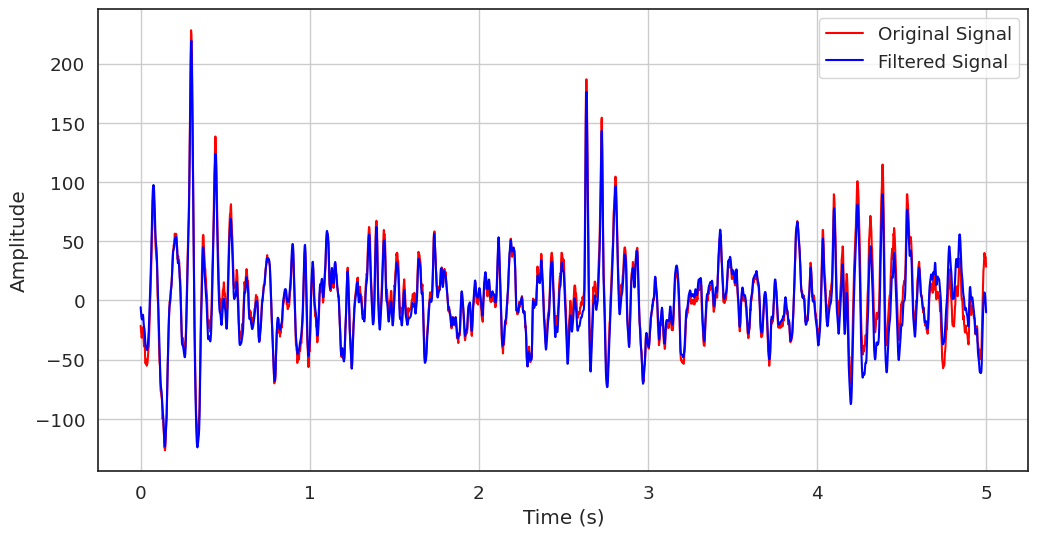

In [45]:
filter_signal_Eat = BandPass_Filter(task_dictionary['TV'][10][:2500], 500, 1, 100)
plot_bandpass(task_dictionary['TV'][10][:2500], filter_signal_Eat,  500)

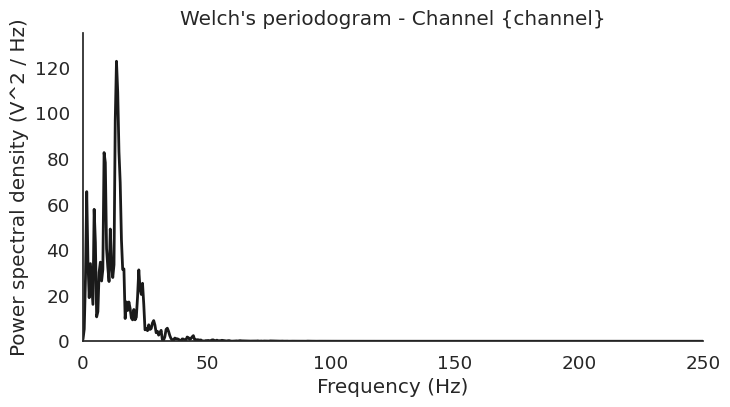

In [46]:
fs = 500.
win = 2 * fs
freqs, psd = scipy.signal.welch(filter_signal_Eat, fs, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram - Channel {channel}")
plt.xlim([0, freqs.max()])
sns.despine()


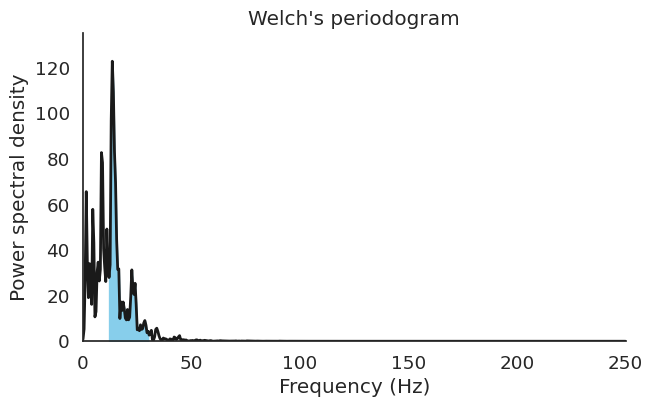

In [47]:
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.xlim([0, 250])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [48]:
# @title mean of band power
delta_TV = bandpower_task(filtered_dict_TV, 5, 500, 0.5, 4)
theta_TV = bandpower_task(filtered_dict_TV, 5, 500, 4, 8)
alpha_TV = bandpower_task(filtered_dict_TV, 5, 500, 8, 12)
beta_TV = bandpower_task(filtered_dict_TV, 5, 500, 12, 30)
gamma_TV = bandpower_task(filtered_dict_TV, 5, 500, 30, 100)

## Computer/phone

In [49]:
# @title Dataset of Computer/phone task
task_dictionary['Computer/phone']

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,89,90,91,92,93
0,-8.631731,1.203731,-1.272789,-16.092970,31.046825,-107.356003,76.765495,-13.592014,-42.855213,-10.867508,...,-5.410736,32.261608,5.410736,-9.404539,-18.925701,-59.850544,10.777938,64.388863,-116.256569,-10.777938
1,-9.824109,0.307153,1.013119,-0.307153,53.630161,-90.533096,100.933655,-24.422642,-44.598690,-12.692369,...,1.154085,34.093430,18.956600,-8.797241,-19.132000,-55.525578,8.152304,70.951515,-113.051743,-8.152304
2,-5.457554,4.158033,5.674887,19.739271,82.302277,-59.519928,110.179123,-32.949070,-47.830978,-11.371252,...,3.772185,39.690651,44.206440,-9.659073,-25.299847,-56.479473,-0.197106,78.508682,-105.818954,0.197106
3,-9.913679,9.533059,3.896866,33.919197,102.831757,-35.603168,104.579300,-44.459324,-52.375904,-12.330559,...,6.471913,57.022713,78.112076,-15.140438,-23.537342,-51.173573,-7.957517,75.144196,-89.577499,7.957517
4,-15.697252,25.421371,3.746412,41.781502,120.565536,-27.684385,85.640137,-44.505539,-49.647095,-11.123854,...,5.644992,72.927094,103.630234,-21.119583,-20.222721,-62.573803,-5.761624,74.540436,-86.254303,5.761625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238980,-65.774704,-83.602890,22.285639,37.764076,52.947388,58.446136,63.441460,48.594749,22.431911,-9.021465,...,13.920802,65.375694,-25.528254,32.167107,-13.920803,-71.199554,-57.639244,85.195572,8.796476,249.678741
238981,-69.737518,-84.663040,19.637033,34.045269,34.617817,53.254028,76.013138,44.054237,16.634550,-1.450287,...,12.195029,59.951637,-24.283726,37.737576,-12.195029,-57.689461,-58.673248,100.594688,1.574510,277.370392
238982,-74.044418,-84.838425,12.725286,22.124437,21.582802,39.969612,70.492523,32.883377,12.861394,1.930918,...,5.014232,50.100426,-21.304775,49.375179,-5.014232,-32.375610,-73.476135,103.243195,12.100042,290.246338
238983,-73.934883,-78.770378,9.810764,19.421320,12.112273,30.906551,64.835358,23.078131,12.056921,9.510215,...,-3.982874,31.331081,-29.412722,54.129784,3.982874,-30.978033,-87.839661,98.536636,3.564472,281.467621


In [50]:
# @title separate 90% for training and 10% for test _Computer/phone
#en(task_dictionary['Computer/phone'])
training_perc_Computer_phone = int(len(task_dictionary['Computer/phone'])*0.9)
training_Computer_phone = task_dictionary['Computer/phone'][:training_perc_Computer_phone]
test_Computer_phone = task_dictionary['Computer/phone'][training_perc_Computer_phone:]
print(training_Computer_phone)

               1          2         3          4           5           6   \
0       -8.631731   1.203731 -1.272789 -16.092970   31.046825 -107.356003   
1       -9.824109   0.307153  1.013119  -0.307153   53.630161  -90.533096   
2       -5.457554   4.158033  5.674887  19.739271   82.302277  -59.519928   
3       -9.913679   9.533059  3.896866  33.919197  102.831757  -35.603168   
4      -15.697252  25.421371  3.746412  41.781502  120.565536  -27.684385   
...           ...        ...       ...        ...         ...         ...   
215081        NaN        NaN       NaN        NaN         NaN         NaN   
215082        NaN        NaN       NaN        NaN         NaN         NaN   
215083        NaN        NaN       NaN        NaN         NaN         NaN   
215084        NaN        NaN       NaN        NaN         NaN         NaN   
215085        NaN        NaN       NaN        NaN         NaN         NaN   

                7          8          9          10  ...        83         

In [51]:
# @title filter each channel and plot spectogram
filtered_dict_Computer_phone = {}
for channel in task_dictionary['Computer/phone']:
  filter_signal_Computer_phone = BandPass_Filter(task_dictionary['Computer/phone'][channel], 500, 1, 100)
  filtered_dict_Computer_phone[channel] = filter_signal_Computer_phone
  #f, t, Sxx = spectrogram(filter_signal_Computer/phone, 500, 100)
  #plot_spectogram(f, t, Sxx, channel)

In [52]:
# @title mean of band power
delta_Computer_phone = bandpower_task(filtered_dict_Computer_phone, 5, 500, 0.5, 4)
theta_Computer_phone = bandpower_task(filtered_dict_Computer_phone, 5, 500, 4, 8)
alpha_Computer_phone = bandpower_task(filtered_dict_Computer_phone, 5, 500, 8, 12)
beta_Computer_phone = bandpower_task(filtered_dict_Computer_phone, 5, 500, 12, 30)
gamma_Computer_phone = bandpower_task(filtered_dict_Computer_phone, 5, 500, 30, 100)

## Sleep/rest

In [53]:
# @title Dataset of Sleep/rest task
task_dictionary['Sleep/rest']

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,89,90,91,92,93
0,51.482754,0.242426,9.277393,-4.620829,17.462975,-10.002975,-20.520609,-0.242426,-11.993029,29.260023,...,-16.690277,8.411592,60.184387,-28.946156,-8.411592,44.581589,66.041725,10.251692,-10.251692,-38.084175
1,58.318478,-1.758973,5.332105,-2.122111,25.104322,-13.747599,-28.402134,-3.920600,-9.784174,32.113487,...,-7.078347,7.078347,62.024479,-30.621958,-9.057644,32.015411,48.238762,-2.835293,2.835293,-51.334442
2,61.562489,1.927790,6.632460,-1.698926,20.360126,-18.346054,-35.995941,-9.435933,-9.641341,30.379158,...,2.598808,-2.598808,49.542606,-41.515366,-11.652188,27.882172,35.897293,-10.241982,10.241985,-55.410706
3,64.333092,11.668564,8.639408,1.496575,10.921474,-22.772203,-38.727119,-15.822037,-12.425129,29.427910,...,12.132604,-12.957063,39.515808,-43.209965,-12.132604,32.772842,30.043205,-15.930229,15.930225,-51.637806
4,61.747757,11.879466,4.893889,4.957002,21.964800,-25.208561,-33.064201,-19.848087,-14.299621,26.016371,...,13.602846,-13.602846,35.635815,-50.061470,-14.979668,32.881100,25.772869,-23.868458,23.868458,-50.732349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179096,6.612755,35.726921,25.758663,-1.703446,32.390148,-26.787743,8.469870,-37.922897,15.636443,6.532959,...,-26.820656,14.770367,-19.682320,14.614077,17.750238,-47.143646,12.228552,27.603537,36.453117,-31.555029
179097,0.369114,28.288946,23.923880,-4.133924,24.205738,-25.874222,12.366038,-37.864983,8.410396,5.709068,...,-27.298868,9.060588,-24.893293,23.120220,18.866907,-45.567009,9.512080,23.030899,23.674183,-33.841049
179098,0.940223,18.342175,15.599707,-15.435793,4.257498,-22.882160,8.674292,-40.023857,1.703324,-0.606580,...,-18.596359,2.801586,-34.171257,29.612133,19.698515,-43.463909,0.609626,25.201626,34.940689,-37.826805
179099,0.968577,8.509197,7.390123,-9.406753,-30.594492,-16.814121,7.798561,-34.859329,7.598206,-7.016008,...,-11.390439,-10.075116,-34.094784,42.300819,20.088604,-39.610306,-2.916788,19.248089,43.100571,-36.022789


In [54]:
# @title separate 90% for training and 10% for test _Sleep/rest
#en(task_dictionary['Sleep/rest'])
training_perc_Sleep_rest = int(len(task_dictionary['Sleep/rest'])*0.9)
training_Sleep_rest = task_dictionary['Sleep/rest'][:training_perc_Sleep_rest]
test_Sleep_rest = task_dictionary['Sleep/rest'][training_perc_Sleep_rest:]
print(training_Sleep_rest)

               1          2         3          4          5          6   \
0       51.482754   0.242426  9.277393  -4.620829  17.462975 -10.002975   
1       58.318478  -1.758973  5.332105  -2.122111  25.104322 -13.747599   
2       61.562489   1.927790  6.632460  -1.698926  20.360126 -18.346054   
3       64.333092  11.668564  8.639408   1.496575  10.921474 -22.772203   
4       61.747757  11.879466  4.893889   4.957002  21.964800 -25.208561   
...           ...        ...       ...        ...        ...        ...   
161185   1.363221  -3.023984  5.244861  -0.628921  -8.193567 -37.607998   
161186  -2.486740  -7.603443  3.332359  -0.434439  -5.101823 -37.029255   
161187  -8.596212 -14.033157  1.225124  -0.758095 -11.211079 -31.365259   
161188  -8.837789 -11.840556 -1.477122 -11.817676 -17.593140 -27.025017   
161189  -1.907820   2.178275 -4.428061 -26.545963 -22.267975 -21.709099   

               7          8          9          10  ...         83         84  \
0      -20.520609 

In [55]:
# @title filter each channel and plot spectogram
filtered_dict_Sleep_rest = {}
for channel in task_dictionary['Sleep/rest']:
  filter_signal_Sleep_rest = BandPass_Filter(task_dictionary['Sleep/rest'][channel], 500, 1, 100)
  filtered_dict_Sleep_rest[channel] = filter_signal_Sleep_rest
  #f, t, Sxx = spectrogram(filter_signal_Sleep_rest, 500, 100)
  #plot_spectogram(f, t, Sxx, channel)

In [56]:
# @title mean of band power
delta_Sleep_rest = bandpower_task(filtered_dict_Sleep_rest, 5, 500, 0.5, 4)
theta_Sleep_rest = bandpower_task(filtered_dict_Sleep_rest, 5, 500, 4, 8)
alpha_Sleep_rest = bandpower_task(filtered_dict_Sleep_rest, 5, 500, 8, 12)
beta_Sleep_rest = bandpower_task(filtered_dict_Sleep_rest, 5, 500, 12, 30)
gamma_Sleep_rest = bandpower_task(filtered_dict_Sleep_rest, 5, 500, 30, 100)

## Inactive

In [57]:
# @title Dataset of Inactive task
task_dictionary['Inactive']

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,89,90,91,92,93
0,153.223083,-15.768907,-30.484852,-74.689224,-79.103943,31.765465,-8.646074,-47.367741,-41.518959,-19.204449,...,-69.000320,51.077579,-14.348599,5.177324,1.988968,3.679482,23.947128,13.302048,-3.679485,-32.006561
1,138.124466,-22.320488,-38.911148,-84.663925,-82.917694,38.026989,5.663452,-49.606209,-64.901413,-32.865108,...,-77.242432,38.460358,-23.934893,4.981686,5.596058,28.817177,14.433105,11.401329,-11.401325,-36.572872
2,127.924637,-16.877768,-39.320885,-84.905602,-86.075882,47.701641,33.893173,-40.643604,-72.259911,-35.288551,...,-78.466667,25.306894,-30.444471,10.685186,8.548214,29.000458,11.446037,33.962128,-15.104141,-11.446045
3,125.078224,-14.158159,-38.370968,-86.690773,-81.759888,54.741287,55.012749,-35.190094,-73.984070,-40.293156,...,-86.636536,4.967678,-46.927696,2.285816,4.943848,35.982689,-0.457428,44.050644,-18.003876,0.457420
4,123.676003,-13.453228,-39.059711,-88.471100,-68.994682,55.095406,67.703728,-30.684216,-70.969269,-42.050694,...,-82.097824,6.221643,-51.389103,7.313507,12.045467,16.937805,5.517548,41.309677,-6.397030,-5.517548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240695,-42.009155,-32.986427,69.642197,139.082458,75.661972,54.335804,27.132246,103.110825,-94.227379,3.781996,...,-12.680035,-15.754955,12.680031,80.136330,-24.759247,-139.309677,-13.513405,23.616928,13.513397,49.836273
240696,-47.194061,-23.746811,73.236755,127.775826,70.989273,56.792488,18.540609,112.785843,-84.279732,9.782034,...,-6.246370,-11.875444,6.246368,98.577316,-18.291527,-167.731949,-14.862480,14.862473,40.581863,39.844070
240697,-47.808037,-15.938328,72.607948,109.625900,51.282196,56.943012,6.413021,123.080849,-70.142143,15.158649,...,15.444580,0.966927,-0.966925,145.550095,-9.159312,-185.922409,-32.376160,51.085571,52.761993,32.376144
240698,-51.421001,-15.581547,62.217121,82.326721,36.315758,46.673988,1.456959,121.592712,-65.037720,15.276485,...,20.541695,3.836966,-21.067583,198.302948,-3.836967,-168.925903,-27.440216,83.222458,102.176804,27.440216


In [58]:
# @title separate 90% for training and 10% for test _Inactive
#en(task_dictionary['Inactive'])
training_perc_Inactive = int(len(task_dictionary['Inactive'])*0.9)
training_Inactive = task_dictionary['Inactive'][:training_perc_Inactive]
test_Inactive = task_dictionary['Inactive'][training_perc_Inactive:]
print(training_Inactive)

                1          2          3          4          5          6   \
0       153.223083 -15.768907 -30.484852 -74.689224 -79.103943  31.765465   
1       138.124466 -22.320488 -38.911148 -84.663925 -82.917694  38.026989   
2       127.924637 -16.877768 -39.320885 -84.905602 -86.075882  47.701641   
3       125.078224 -14.158159 -38.370968 -86.690773 -81.759888  54.741287   
4       123.676003 -13.453228 -39.059711 -88.471100 -68.994682  55.095406   
...            ...        ...        ...        ...        ...        ...   
216625  -11.091592   8.380058 -12.865828   2.961966  22.622751 -33.750504   
216626  -17.274227   5.033604 -17.886093   2.720566  25.432884 -34.761948   
216627  -19.561277   4.395304 -21.485521   4.912252  27.414545 -29.077187   
216628  -16.463966  -0.436227 -25.335724  11.174998  28.625313 -29.673283   
216629  -16.744818  -0.286110 -25.570036  10.015478  14.654745 -35.987595   

               7          8          9          10  ...         83         

In [59]:
# @title filter each channel and plot spectogram
filtered_dict_Inactive = {}
for channel in training_Inactive:
  filter_signal_Inactive = BandPass_Filter(training_Inactive[channel], 500, 1, 100)
  filtered_dict_Inactive[channel] = filter_signal_Inactive
  #f, t, Sxx = spectrogram(filter_signal_Inactive, 500, 100)
  #plot_spectogram(f, t, Sxx, channel)

In [60]:
# @title mean of band power
delta_Inactive = bandpower_task(filtered_dict_Inactive, 5, 500, 0.5, 4)
theta_Inactive = bandpower_task(filtered_dict_Inactive, 5, 500, 4, 8)
alpha_Inactive = bandpower_task(filtered_dict_Inactive, 5, 500, 8, 12)
beta_Inactive = bandpower_task(filtered_dict_Inactive, 5, 500, 12, 30)
gamma_Inactive = bandpower_task(filtered_dict_Inactive, 5, 500, 30, 100)

# PCA

In [61]:
from scipy.stats import zscore
df_scaled = pd.DataFrame(beta_Eat)
df_scaled2 = pd.DataFrame(beta_TV)
df_scaled2

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,89,90,91,92,93
0,497.379039,493.037719,519.066281,1442.899027,2547.072154,599.452395,1047.670774,553.151821,640.199579,460.783180,...,387.659485,261.282332,433.914964,1356.128467,189.567628,526.249234,719.233640,518.232626,890.185023,453.529322
1,366.045529,404.925208,481.812207,1434.505474,2659.266856,412.427542,1076.963063,452.628918,699.358292,362.635741,...,603.381592,358.730164,651.483451,948.901849,185.659900,638.905036,806.882739,542.313300,587.595559,507.472784
2,265.618419,361.925919,487.558326,1596.402212,2389.737017,337.492626,674.402763,479.081213,570.246483,312.167418,...,874.334065,306.550467,540.763161,817.210241,221.750393,545.745049,477.283680,555.780798,856.921068,439.748998
3,121.086233,280.663058,383.753705,1293.245560,2358.331449,677.882332,694.507499,223.631374,401.498162,271.481895,...,297.690709,181.361802,462.591951,928.385493,109.682105,450.220917,429.590942,545.528438,496.907740,314.011700
4,116.104503,389.221175,340.278264,1182.916708,3444.279684,846.961302,879.338715,198.413832,287.540888,174.108727,...,206.488426,160.904033,386.174443,757.309219,110.304857,265.061650,224.456369,225.791003,424.786555,308.775860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,507.682150,154.440030,218.508382,551.056422,954.307182,337.366399,483.110205,268.567080,415.614540,154.818670,...,1117.287867,224.269070,384.224735,1602.231071,151.706555,1514.037110,1004.974970,1198.007268,1106.700219,763.374334
93,492.112552,315.712402,723.860212,2042.190200,2910.205733,1285.316809,1030.261258,443.260140,437.564586,298.754904,...,1174.144903,343.775111,670.807735,1471.689014,212.778553,2328.202865,1772.595958,1023.301679,1750.574130,1005.858821
94,268.024856,251.038973,715.855512,1949.985082,5337.835669,1584.272848,1472.580117,316.922661,248.481394,317.169020,...,806.265203,330.105471,594.601877,1434.134905,143.675082,1200.361006,981.206089,991.673165,1249.914576,774.615380
95,265.405337,191.448386,263.294855,607.186150,982.279400,321.858371,448.596534,246.401182,285.468194,218.145094,...,993.299740,470.303962,665.037562,1553.546830,228.005543,1978.522612,1068.933264,1054.303079,1591.644289,940.445011


In [62]:
# Load the PCA function from sklearn.decomposition
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(df_scaled)

#proportion of variance explained
# print(df_scaled)
print(pca.explained_variance_ratio_)


#eigenvalues
print(pca.explained_variance_)


#eigenvectors
print(np.abs(pca.components_))


pca2 = PCA(n_components=1) # of course the max is 1
pca2.fit(df_scaled2)

#proportion of variance explained
print(pca2.explained_variance_ratio_)



#eigenvalues
print(pca2.explained_variance_)


#eigenvectors
print(np.abs(pca2.components_))


[0.4460567]
[4433138.62508845]
[[6.89364134e-02 1.96692726e-02 7.84833532e-02 2.02442340e-01
  5.12334366e-01 1.69143586e-01 2.17516675e-01 5.20407445e-02
  4.94972940e-02 5.44758189e-02 1.50259001e-01 4.50790669e-01
  3.03945534e-01 2.94148077e-01 1.02248825e-01 1.86921114e-02
  2.34225919e-02 1.41631175e-01 1.05830166e-01 8.91927435e-02
  1.43410687e-01 8.11181931e-02 5.99045122e-03 5.35007457e-03
  2.36893730e-02 4.24863565e-02 1.85058660e-02 4.54066676e-02
  2.27701441e-02 1.39842788e-03 1.49204255e-03 4.24654834e-04
  2.21930463e-03 5.05047133e-05 4.10906348e-03 4.03405040e-03
  1.20354794e-03 7.25326106e-03 4.53004539e-02 4.45305255e-02
  2.56803635e-02 6.91190281e-03 4.01142038e-02 2.43803284e-02
  2.55246570e-02 3.19031002e-02 2.81732496e-02 1.97513982e-03
  4.35145372e-02 3.39890601e-02 7.57283542e-02 6.75701487e-02
  1.04411561e-02 1.20892615e-02 4.21368114e-02 3.33572471e-02
  1.85847590e-02 9.13486016e-02 4.28728430e-03 2.89375218e-03
  1.39166015e-02 7.39620597e-03 1.72147

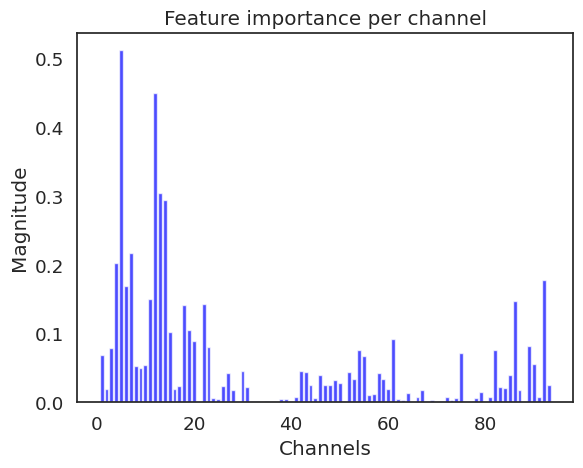

In [63]:
channels = df_scaled.columns.tolist()
components = np.abs(pca.components_)
plt.bar(channels, components[0], color='blue', alpha=0.7)
plt.title('Feature importance per channel')
plt.xlabel('Channels')
plt.ylabel('Magnitude')

# Exibir o gráfico
plt.show()

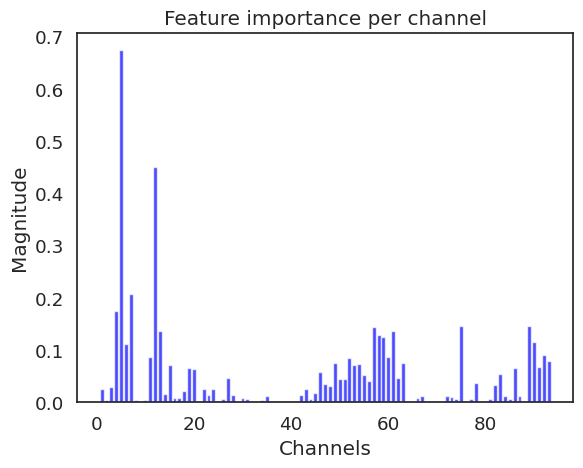

In [64]:
channels = df_scaled2.columns.tolist()
components = np.abs(pca2.components_)
plt.bar(channels, components[0], color='blue', alpha=0.7)
plt.title('Feature importance per channel')
plt.xlabel('Channels')
plt.ylabel('Magnitude')

# Exibir o gráfico
plt.show()


In [65]:
principalComponents1 = pd.DataFrame(pca.transform(df_scaled))

arr1  = principalComponents1.to_numpy()
# CorrespVal=['Eat' * len(arr1)].T
CorrespVal = np.full(len(arr1),1) # 1 for Eat
principalComponents2 = pd.DataFrame(pca.transform(df_scaled2))
arr2  = principalComponents2.to_numpy()
arr1=np.concatenate((arr1,arr2),axis=0)
# CorrespVal2=['TV' * len(arr2)].T
CorrespVal2 = np.full(len(arr2),0) #0 fo TV
CorrespVal=(np.concatenate((CorrespVal,CorrespVal2),axis=0))

#Corresval and arr1 are the LR inputs

CorrespVal=CorrespVal.reshape(len(CorrespVal),1)
# print(arr1.shape)
# print(CorrespVal.shape)
# arr1
# principalComponents1

# Logistic Regression

[-1870.82351059  -642.60537238  -118.05941289  -260.72281633
 -2186.54489497 -2224.77297663 -2270.31647826  -360.42087112
  -186.66291317 -1411.62258585  -417.6484951    -47.38643589
 -2707.88291725 -2156.67796006  -455.20474539 -1029.87771283
   -50.44758655   -72.89647877   229.01808732   278.70209617
  -639.45455241 -2087.07082927  -724.43434504 -1893.1757907
  -610.8760351   4644.20488787  3483.31206649  4725.24760773
  3214.55971478  3508.66773422  3366.51963458 -1448.81133269
 -1067.0191546   -846.32530418  -358.65226498  3775.17835512
  2558.02335132  1679.4760563   4545.11129538 -1210.81239015
 -1027.24978184   502.98381083  2727.70482729 -1749.61571555
 -1431.52422672 -2126.11854446 -1715.52186411 -1831.47322956
  1933.80357761  1235.7361506   1273.7243107    961.12086579
  1513.45006383  1019.6110334     11.14851442  1449.2546261
  -124.0519742   1848.58963835  3204.17253339  1555.28342641
   629.7701883   1292.27870611   377.03738355  1698.44970565
  1010.436171    1238.8621

<Axes: xlabel='Power spectral density', ylabel='Category'>

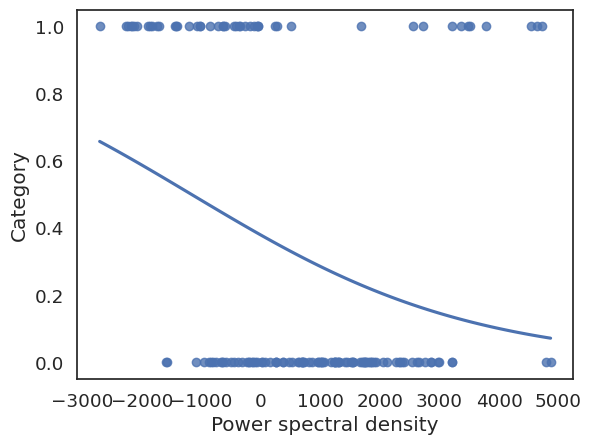

In [66]:
import seaborn as sns

arr1=arr1.reshape(len(arr1),)

CorrespVal=CorrespVal.reshape(len(CorrespVal),)

columns=['Power_Spectral','Category']

print(arr1)

print(CorrespVal)

df=pd.DataFrame({"Power spectral density":arr1,"Category":CorrespVal})


sns.regplot(x='Power spectral density', y='Category', data=df, logistic=True, ci=None)

In [67]:
from sklearn.model_selection import train_test_split

X= arr1
X = X.reshape(-1, 1)
y = CorrespVal
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [68]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [69]:
prediction = logreg.predict(X_test)

In [70]:
# from sklearn.metrics import classification_report


# print(pca.explained_variance_ratio_)

# diction))
from sklearn.metrics import classification_report

print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84        20
           1       0.75      0.33      0.46         9

    accuracy                           0.76        29
   macro avg       0.76      0.64      0.65        29
weighted avg       0.76      0.76      0.73        29



[[19  1]
 [ 6  3]]


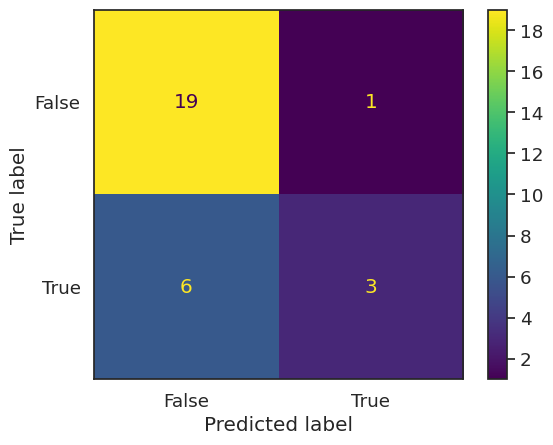

In [71]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_matrix = confusion_matrix(y_test,prediction)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.578


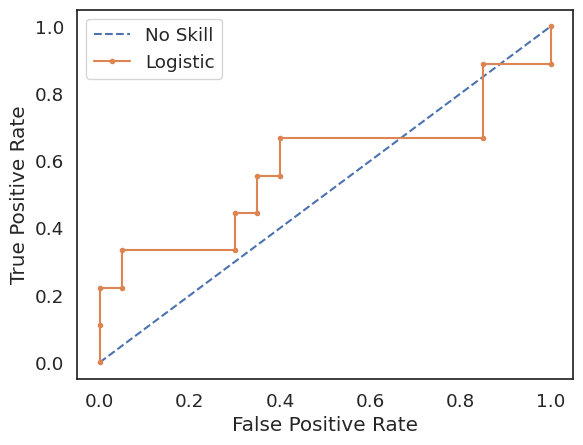

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(X_test, y_test)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()